#**Sentiment Analysis on Amazon Reviews of Mobile Electronics:**

NLP Fall 2023
Group Members: Aashna Shroff, Samruddhi Dhumane, Dharita Desai, Varshin Bhaskaran

In [4]:
!pip install spacy==3.6.0
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 13.3 MB/s eta 0:00:00
  Attempting uninstall: spacy
    Found existing installation: spacy 3.6.1
    Uninstalling spacy-3.6.1:
      Successfully uninstalled spacy-3.6.1
2023-11-30 23:15:31.890498: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-30 23:15:31.890553: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-30 23:15:31.890584: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-30 23:15:31.898494: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available C

In [5]:
from transformers import DistilBertTokenizerFast
from transformers import TFDistilBertForSequenceClassification
import pandas as pd
import numpy as np
import nltk
import re
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [7]:

from google.colab import drive

# Mount Google Drive
drive.mount('/drive')

# Update the file path with the correct path on your Google Drive
file_path = '/drive/My Drive/Colab Notebooks/NLP/amazon_reviews_us_Mobile_Electronics_v1_00.tsv'

df = pd.read_csv(file_path, delimiter='\t', encoding='utf-8', error_bad_lines=False)

df["Sentiment"] = df['star_rating'].apply(lambda score: "positive" if score >= 3 else "negative")
df['Sentiment'] = df['Sentiment'].map({'positive': 1, 'negative': 0})

df['short_review'] = df['review_body'].apply(lambda x: x.decode("utf-8") if isinstance(x, bytes) else x)
df1 = df[["short_review", "Sentiment"]]



Mounted at /drive


<ipython-input-7-1141d49c0f38>:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df = pd.read_csv(file_path, delimiter='\t', encoding='utf-8', error_bad_lines=False)
Skipping line 35246: expected 15 fields, saw 22

Skipping line 87073: expected 15 fields, saw 22



# **Exploratory Data Analysis**

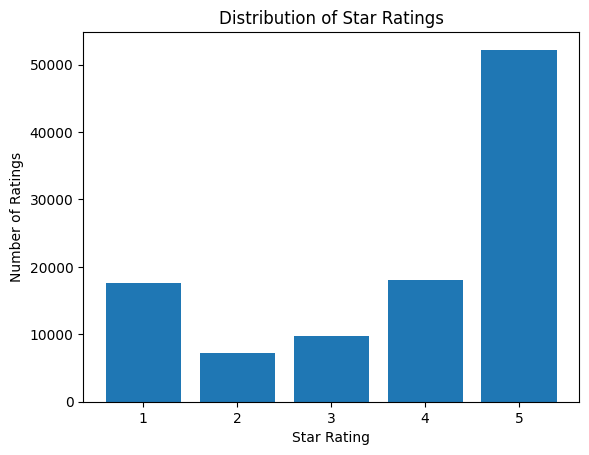

In [9]:
# Visualizing Star Rating Distribution with a Bar Chart

import pandas as pd
import matplotlib.pyplot as plt

# Plotting the counts as a bar graph
plt.bar(rating_counts.index, rating_counts.values)
plt.xlabel('Star Rating')
plt.ylabel('Number of Ratings')
plt.title('Distribution of Star Ratings')
plt.xticks([1.0, 2.0, 3.0, 4.0, 5.0])  # Setting the x-ticks to match the star ratings
plt.show()


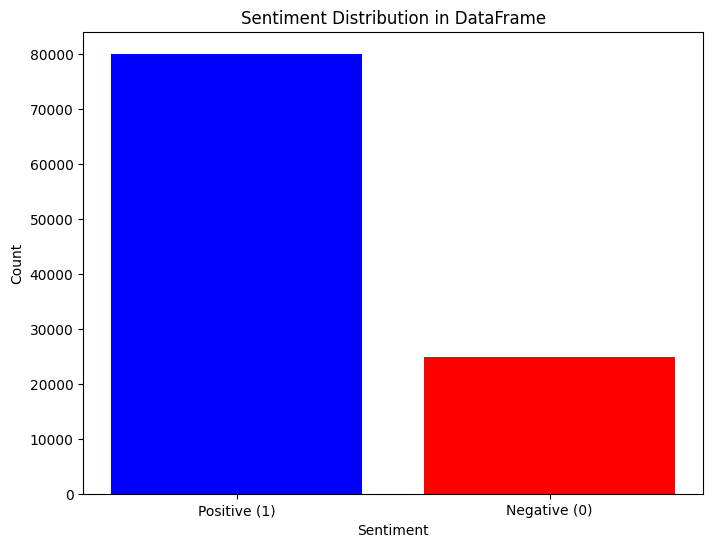

In [10]:
# Positive and Negative Reviews in the Dataset
import pandas as pd

# Assuming df is your DataFrame
count_ones = df['Sentiment'].sum()  # Count of 1's
count_zeros = len(df) - count_ones  # Count of 0's

counts = [count_ones, count_zeros]

# Labels for the bar chart
labels = ['Positive (1)', 'Negative (0)']

# Creating the bar graph
plt.figure(figsize=(8, 6))
plt.bar(labels, counts, color=['blue', 'red'])
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Distribution in DataFrame')
plt.show()

In [11]:
# Review Counts by Product ID in dataset

reviews_per_product = df.groupby(['product_id', 'product_title'])['short_review'].count().reset_index()

reviews_per_product = reviews_per_product.rename(columns={'review': 'review_count'})
reviews_per_product

,product_id,product_title,short_review
0,0528007262,Rand McNally TND 720 LM IntelliRoute Truck GPS...,13
1,0594012015,Barnes & Noble NOOK Power Kit in Carbon BNADPN31,25
2,0594450187,"Barnes & Noble 7"" Lautner Cover Crimson NOOK Case",2
3,0594450209,"Barnes & Noble 7"" Lautner Chocolate NOOK Case",3
4,0594450306,"Barnes & Noble Nook HD+ Seaton Cover, Violet",1
...,...,...,...
25792,B0131NRA9Q,Pax 2 Hard Plastic Case (Black),8
25793,B013AJYRCY,"Portable Bluetooth Speaker,sound Cube Portable...",3
25794,B013OGQME4,[Most Powerful Portable Speaker Ever]Omaker 10...,2
25795,B01416742A,Powerful Wireless Bluetooth Speaker with High ...,2


In [12]:
df1

,short_review,Sentiment
0,"As advertised. Everything works perfectly, I'm...",1
1,it's great,1
2,These work great and fit my life proof case fo...,1
3,Work very well but couldn't get used to not he...,1
4,"Be careful with these products, I have bought ...",0
...,...,...
104847,"I've been looking for a while for the \\""purr\...",1
104848,We live in an apartment with hardwood floors a...,1
104849,I received this for a birthday present and Its...,1
104850,I got the Dirt Devil Spot Scrubber for a gift ...,1


In [13]:
df1.shape

(104852, 2)

In [14]:
df1['Sentiment'].value_counts()

1    79981
0    24871
Name: Sentiment, dtype: int64

In [15]:
df1.isnull().sum()

short_review    3
Sentiment       0
dtype: int64

In [16]:
# Remove rows where 'Review' column has missing values
df1 = df1.dropna(subset=['short_review'])

# Display the DataFrame after removal of missing values
df1


,short_review,Sentiment
0,"As advertised. Everything works perfectly, I'm...",1
1,it's great,1
2,These work great and fit my life proof case fo...,1
3,Work very well but couldn't get used to not he...,1
4,"Be careful with these products, I have bought ...",0
...,...,...
104847,"I've been looking for a while for the \\""purr\...",1
104848,We live in an apartment with hardwood floors a...,1
104849,I received this for a birthday present and Its...,1
104850,I got the Dirt Devil Spot Scrubber for a gift ...,1


# Preprocessing, Training & Testing for Spacy Model




In [33]:
import string

In [34]:
punct = string.punctuation
punct

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [35]:
import spacy

nlp = spacy.load('en_core_web_sm')


In [36]:
from spacy.lang.en.stop_words import STOP_WORDS
stopwords = list(STOP_WORDS)
len(stopwords)

326

In [37]:
def text_data_cleaning(sentence):
    doc = nlp(sentence)

    tokens = []

    for token in doc:
        if token.lemma_ != "-PRON-": # Performing Sentence Lemmatization if it is not pronoun.
            temp = token.lemma_.lower().strip()
        else:
            temp = token.lower_

        tokens.append(temp) # Lemmatized and converted text into lowercase.

        # Clean tokens.
        cleaned_tokens = []

        for token in tokens:
            if token not in stopwords and token not in punct:
                cleaned_tokens.append(token)
        return cleaned_tokens

In [38]:
# TF-IDF

In [39]:
from sklearn.svm import LinearSVC

tfidf = TfidfVectorizer(tokenizer = text_data_cleaning)
classifier = LinearSVC()

In [40]:
X = df1['short_review']
y = df1['Sentiment']

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=42)

In [42]:
# Creating a Pipeline to perform TFidf and classifier

clf = Pipeline([('tfidf', tfidf), ('clf', classifier)])

In [43]:
clf.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(tokenizer=<function text_data_cleaning at 0x7ec144f3bb50>)),
                ('clf', LinearSVC())])

In [45]:
#Classification Report

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.08      0.14      7479
           1       0.77      0.99      0.87     23976

    accuracy                           0.77     31455
   macro avg       0.76      0.53      0.50     31455
weighted avg       0.77      0.77      0.70     31455



In [47]:
# Testing an example with our trained model.

clf.predict(['Bad Product Bad food'])

array([0])

In [48]:
# Testing an example with our trained model.

clf.predict(['Good Product']) # 1 Means Positive Review.

array([1])

# Preprocessing, Training & Testing for BERT Model

In [17]:
import math
import numpy as np
import pandas as pd
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import re
import spacy
import torch
import transformers

from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.dummy import DummyClassifier

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from tqdm.auto import tqdm

In [18]:
# Function to decode or convert review text
def decode_review(review):
    if pd.isnull(review):
        return ""  # or some other placeholder for missing values
    elif isinstance(review, bytes):
        return review.decode("utf-8")
    elif isinstance(review, str):
        return review
    else:
        return str(review)  # Convert other types to string

In [19]:
#Decoding and Cleaning Review Data"

def clean_string(text):
    s = re.sub(r"[^a-zA-Z']", ' ', text)
    return (' '.join(s.split())).lower()

In [20]:
df1['review_norm'] = df1["short_review"].apply(clean_string)
display(df1['review_norm'].sample(5))

<ipython-input-20-b3131d2b7c7a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['review_norm'] = df1["short_review"].apply(clean_string)


16565                               quick service work well
22755                                              thankyou
103484    i mean it has been a stressful experience tryi...
41356     good price quick delivery and excellent blueto...
22214     do not like makes the speaker sound like crap ...
Name: review_norm, dtype: object

In [21]:
from sklearn.model_selection import train_test_split

X1 = df1['review_norm']
y1 = df1['Sentiment']

X1_train, X1_test, y1_train, y1_test = train_test_split(X1,y1,test_size=0.3, random_state=42)

In [22]:
#Initializing BERT Model and Tokenizer

okenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [23]:
#BERT Embeddings Generation process

def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):
    ids_list = []
    attention_mask_list = []

    for input_text in texts:
        ids = tokenizer.encode(input_text, add_special_tokens=True, truncation=True, max_length=max_length)
        padded = np.array(ids + [0]*(max_length - len(ids)))
        attention_mask = np.where(padded != 0, 1, 0)
        ids_list.append(padded)
        attention_mask_list.append(attention_mask)

    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model.to(device)
    if not disable_progress_bar:
        print(f'Using the {device} device.')

    # get embeddings in batches
    embeddings = []

    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):
        ids_batch = torch.LongTensor(np.array(ids_list[batch_size*i:batch_size*(i+1)])).to(device)
        attention_mask_batch = torch.LongTensor(np.array(attention_mask_list[batch_size*i:batch_size*(i+1)])).to(device)

        with torch.no_grad():
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())

    return np.concatenate(embeddings)

In [24]:
train_features_BERT = BERT_text_to_embeddings(X1_train, force_device='cuda')
test_features_BERT = BERT_text_to_embeddings(X1_test, force_device='cuda')

Using the cuda device.


  0%|          | 0/734 [00:00<?, ?it/s]

Using the cuda device.


  0%|          | 0/315 [00:00<?, ?it/s]

In [25]:
lr_model_BERT = LogisticRegression(random_state=12345, solver='liblinear')
lr_model_BERT.fit(train_features_BERT, y1_train)

LogisticRegression(random_state=12345, solver='liblinear')

In [27]:
#Classification Report

y1_pred = lr_model_BERT.predict(test_features_BERT)
print(classification_report(y1_test, y1_pred))

              precision    recall  f1-score   support

           0       0.81      0.74      0.77      7479
           1       0.92      0.95      0.93     23976

    accuracy                           0.90     31455
   macro avg       0.87      0.84      0.85     31455
weighted avg       0.89      0.90      0.89     31455



**Generating a Comparative Analysis DataFrame for BERT and spaCy Predictions on Review Data**

In [74]:
import pandas as pd

pd.set_option('display.max_colwidth', None)

def label_review(value):
    return 'Positive' if value == 1 else 'Negative'

data = []
for review, pred_bert, pred_spacy, actual in zip(X1_test, y1_pred, y_pred, y1_test):
    data.append({'Review': review,
                 'Predicted_Bert': label_review(pred_bert),
                 'Predicted_SpaCy': label_review(pred_spacy),
                 'Actual': label_review(actual)})

df_bert = pd.DataFrame(data)
df_bert.head(5)


,Review,Predicted_Bert,Predicted_SpaCy,Actual
0,the amp and kit combo was better then i expected would and will definately buy again for my other vehicles,Positive,Positive,Positive
1,this product was amazing for about weeks i plugged my phone into it and drove to the gas station came out turned my car on and the device was dead don't buy it too good to be true,Negative,Positive,Negative
2,the product pictured is the not accessory power gogroove flexsmart x the real flexsmart x which has star average rating with over product reviews can be found here asin b ppgoc gogroove flexsmart x wireless in car bluetooth fm transmitter with charging music control and hands free calling for android iphone blackberry windows smartphones,Positive,Positive,Negative
3,when i was looking for an mp player this one stood out due to the price and the size of the on board storage if i remember correctly there was a few poor reviews on this player i don't get it this little mp player is fantastic for the price i paid it holds a lot of music and can manage video as well someone else said it was difficult to navigate the menu and they couldn't figure out how to load music this is actually very intuitive and doesn't take a lot to get used to the loading of music is actually very simple since you load the device then drag and drop into the folder i've only had this one day but i already like it once i've had this for a while i'll leave another review about the longevity of the device june alright so i've had this player for about a month now and i have to tell you that i'm more than a little upset don't get me wrong the sound quality of the player is great the life of a charged battery is great and the player itself is pretty durable the problem is that while the battery originally held a charge for a loooong time the battery just died on me i can plug the device in and it will function but when i remove it from wall power it shuts down and doesn't work at all my guess is that the battery is unable to maintain its charge without a c power i just can't in good judgement recommend this player for anyone to purchase,Negative,Positive,Negative
4,amazon please take this item down this is not appropriate or safe for any child,Negative,Positive,Negative


**Saving and Loading BERT Model with Joblib**

In [ ]:
import joblib

model_save_path = '/drive/My Drive/Colab Notebooks/NLP/lr_model_BERT.joblib'

joblib.dump(lr_model_BERT, model_save_path)

print(f"Model saved successfully at: {model_save_path}")

In [56]:
import joblib

loaded_model_path = '/drive/My Drive/Colab Notebooks/NLP/lr_model_BERT.joblib'

loaded_lr_model_BERT = joblib.load(loaded_model_path)

In [57]:
sample_text = "This is a great product! I love it."

cleaned_text = clean_string(sample_text)

# Convert the preprocessed text to BERT embeddings
sample_features_BERT = BERT_text_to_embeddings([cleaned_text], force_device='cuda')

# Make predictions using the loaded model
predicted_sentiment = loaded_lr_model_BERT.predict(sample_features_BERT)

# Print the predicted sentiment
print("Predicted Sentiment:", "Positive" if predicted_sentiment[0] == 1 else "Negative")


Using the cuda device.


  0%|          | 0/1 [00:00<?, ?it/s]

Predicted Sentiment: Positive


In [58]:
sample_text = "This is a not a good product! Bad quality."

cleaned_text = clean_string(sample_text)

# Convert the preprocessed text to BERT embeddings
sample_features_BERT = BERT_text_to_embeddings([cleaned_text], force_device='cuda')

# Make predictions using the loaded model
predicted_sentiment = loaded_lr_model_BERT.predict(sample_features_BERT)

# Print the predicted sentiment
print("Predicted Sentiment:", "Positive" if predicted_sentiment[0] == 1 else "Negative")


Using the cuda device.


  0%|          | 0/1 [00:00<?, ?it/s]

Predicted Sentiment: Negative


**`Saving and Loading Spacy Model with Joblib`**

In [49]:
import joblib

model_filename = '/drive/My Drive/Colab Notebooks/NLP/sentiment_model.joblib'
joblib.dump(clf, model_filename)

loaded_model = joblib.load(model_filename)

In [52]:
loaded_model.predict(['Bad Product Bad food'])

array([0])

In [53]:
loaded_model.predict(['Good Product'])

array([1])

**Comparative Performance Analysis of spaCy and BERT Models Across Key**

"\n# Save the plot to a file\nspacy_bert_comparison_graph_path = '/mnt/data/spacy_bert_comparison_graph.png'\nplt.savefig(spacy_bert_comparison_graph_path)\nplt.close()  # Close the plot to avoid displaying it inline;"

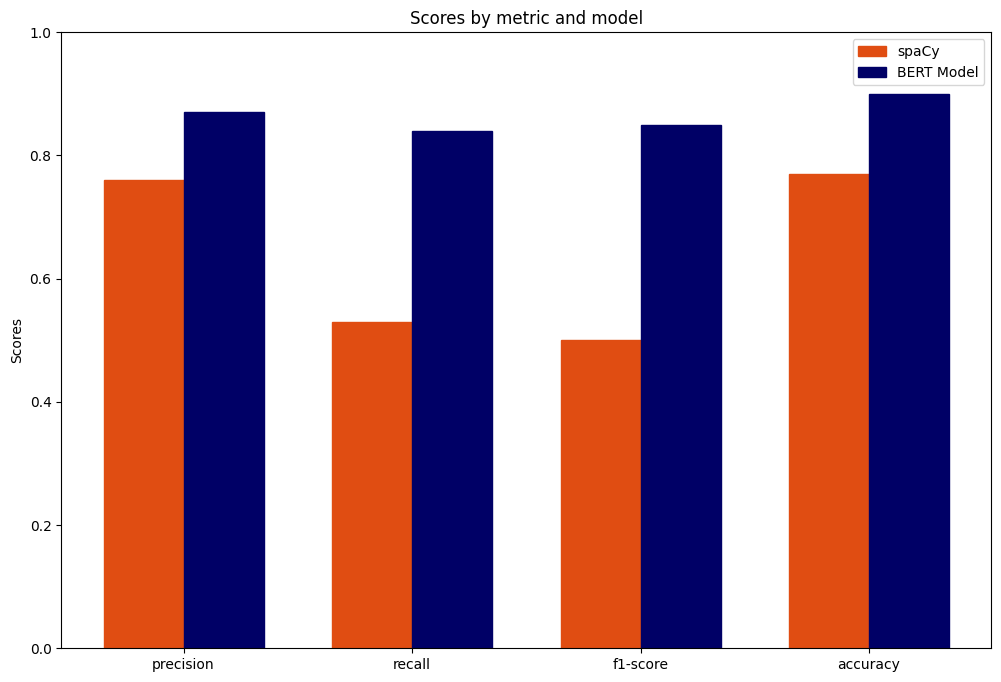

In [64]:
import matplotlib.pyplot as plt
import numpy as np

metrics = ['precision', 'recall', 'f1-score', 'accuracy']
spacy_values = [0.76, 0.53, 0.50, 0.77]
bert_values = [0.87, 0.84, 0.85, 0.90]

ind = np.arange(len(metrics))
width = 0.35


fig, ax = plt.subplots(figsize=(12, 8))
rects1 = ax.bar(ind - width/2, spacy_values, width, label='spaCy',
                color='#E04D12', edgecolor='#E04D12')
rects2 = ax.bar(ind + width/2, bert_values, width, label='BERT Model',
                color='#000066', edgecolor='#000066')

ax.set_ylabel('Scores')
ax.set_title('Scores by metric and model')
ax.set_xticks(ind)
ax.set_xticklabels(metrics)
ax.set_ylim(0, 1)
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom',
                    color='white')

autolabel(rects1)
autolabel(rects2)
